In [2]:
# install presidio evaluator via pip if not yet installed

#!pip install presidio-evaluator

In [3]:
from pathlib import Path
from pprint import pprint
from collections import Counter
from typing import Dict, List
import json

from presidio_evaluator import InputSample
from presidio_evaluator.evaluation import Evaluator, ModelError, Plotter
from presidio_evaluator.experiment_tracking import get_experiment_tracker

import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

%reload_ext autoreload
%autoreload 2
%matplotlib inline

stanza and spacy_stanza are not installed
Flair is not installed by default


## 1. Load dataset from file

In [4]:
dataset_name = "presidio_data_generator_masked_keys.json" #"synth_dataset_v2.json"
dataset = InputSample.read_dataset_json(Path(Path.cwd().parent, "data", dataset_name))
print(len(dataset))

tokenizing input:   0%|          | 0/2000 [00:00<?, ?it/s]

loading model en_core_web_sm


tokenizing input: 100%|██████████| 2000/2000 [00:09<00:00, 208.07it/s]

2000


This dataset was auto generated. See more info here [Synthetic data generation](1_Generate_data.ipynb).

In [5]:
def get_entity_counts(dataset: List[InputSample]) -> Dict:
    """Return a dictionary with counter per entity type."""
    entity_counter = Counter()
    for sample in dataset:
        for tag in sample.tags:
            entity_counter[tag] += 1
    return entity_counter


## 2. Simple dataset statistics

In [6]:
entity_counts = get_entity_counts(dataset)
print("Count per entity:")
pprint(entity_counts.most_common(), compact=True)

print("\nMin and max number of tokens in dataset: "\
f"Min: {min([len(sample.tokens) for sample in dataset])}, "\
f"Max: {max([len(sample.tokens) for sample in dataset])}")

print(f"Min and max sentence length in dataset: " \
f"Min: {min([len(sample.full_text) for sample in dataset])}, "\
f"Max: {max([len(sample.full_text) for sample in dataset])}")

print("\nExample InputSample:")
print(dataset[0])

Count per entity:
[('O', 25475), ('STREET_ADDRESS', 3856), ('PERSON', 1910),
 ('ORGANIZATION', 1366), ('GPE', 620), ('PHONE_NUMBER', 518),
 ('DATE_TIME', 276), ('CREDIT_CARD', 166), ('TITLE', 144), ('US_SSN', 105),
 ('AGE', 101), ('NRP', 90), ('EMAIL_ADDRESS', 58), ('ZIP_CODE', 48),
 ('DOMAIN_NAME', 37), ('IP_ADDRESS', 25), ('IBAN_CODE', 18),
 ('US_DRIVER_LICENSE', 4)]

Min and max number of tokens in dataset: Min: 2, Max: 79
Min and max sentence length in dataset: Min: 9, Max: 427

Example InputSample:
Full text: The bus station is on Via Pasquale Scura 127
Spans: [Span(type: STREET_ADDRESS, value: Via Pasquale Scura 127, char_span: [22: 44])]



In [7]:
print("A few examples sentences containing each entity:\n")
for entity in entity_counts.keys():
    samples = [sample for sample in dataset if entity in set(sample.tags)]
    if len(samples) > 1 and entity != "O":
        print(f"Entity: <{entity}> two example sentences:\n"
              f"\n1) {samples[0].full_text}"
              f"\n2) {samples[1].full_text}"
              f"\n------------------------------------\n")

A few examples sentences containing each entity:

Entity: <STREET_ADDRESS> two example sentences:

1) The bus station is on Via Pasquale Scura 127
2) Csanád had given Csanád his address: 083 254 Damvergi Street, Nicosia
------------------------------------

Entity: <PERSON> two example sentences:

1) Leigha C Mackay\n\nLa Sagne\nSwitzerland
2) Csanád had given Csanád his address: 083 254 Damvergi Street, Nicosia
------------------------------------

Entity: <GPE> two example sentences:

1) Leigha C Mackay\n\nLa Sagne\nSwitzerland
2) Csanád had given Csanád his address: 083 254 Damvergi Street, Nicosia
------------------------------------

Entity: <PHONE_NUMBER> two example sentences:

1) Can someone call me on 06-82237745? I have some questions about opening an account.
2) Francesca Freeman\n\n35116 Rua Arapiraca 1943\n Apt. 559\n Teixeira de Freitas\n Brazil 35172\n(73) 4746-3459-Office\,781-618-4959-Fax
------------------------------------

Entity: <CREDIT_CARD> two example sentences

## 3. Define the AnalyzerEngine object
Using Presidio with default parameters (not recommended, it's used here for simplicity). For an example on customization, see [notebook 5](5_Evaluate_Custom_Presidio_Analyzer.ipynb)

## 4. Align the dataset's entities to Presidio's entities

There is possibly a difference between the names of entities in the dataset, and the names of entities Presidio can detect.
For example, it could be that a dataset labels a name as PER while Presidio returns PERSON. To be able to compare the predicted value to the actual and gather metrics, an alignment between the entity names is necessary. Consider changing the mapping if your dataset and/or Presidio instance supports difference entity types.

In [8]:
from presidio_evaluator.models import  PresidioAnalyzerWrapper

entities_mapping=PresidioAnalyzerWrapper.presidio_entities_map # default mapping

print("Using this mapping between the dataset and Presidio's entities:")
pprint(entities_mapping, compact=True)


dataset = Evaluator.align_entity_types(
    dataset, 
    entities_mapping=entities_mapping, 
    allow_missing_mappings=True
)
new_entity_counts = get_entity_counts(dataset)
print("\nCount per entity after alignment:")
pprint(new_entity_counts.most_common(), compact=True)

dataset_entities = list(new_entity_counts.values())


Using this mapping between the dataset and Presidio's entities:
{'ADDRESS': 'LOCATION',
 'AGE': 'AGE',
 'BIRTHDAY': 'DATE_TIME',
 'CITY': 'LOCATION',
 'CREDIT_CARD': 'CREDIT_CARD',
 'CREDIT_CARD_NUMBER': 'CREDIT_CARD',
 'DATE': 'DATE_TIME',
 'DATE_OF_BIRTH': 'DATE_TIME',
 'DATE_TIME': 'DATE_TIME',
 'DOB': 'DATE_TIME',
 'DOMAIN': 'URL',
 'DOMAIN_NAME': 'URL',
 'EMAIL': 'EMAIL_ADDRESS',
 'EMAIL_ADDRESS': 'EMAIL_ADDRESS',
 'FACILITY': 'LOCATION',
 'FIRST_NAME': 'PERSON',
 'GPE': 'LOCATION',
 'HCW': 'PERSON',
 'HOSP': 'ORGANIZATION',
 'HOSPITAL': 'ORGANIZATION',
 'IBAN': 'IBAN_CODE',
 'IBAN_CODE': 'IBAN_CODE',
 'ID': 'ID',
 'IP_ADDRESS': 'IP_ADDRESS',
 'LAST_NAME': 'PERSON',
 'LOC': 'LOCATION',
 'LOCATION': 'LOCATION',
 'NAME': 'PERSON',
 'NATIONALITY': 'NRP',
 'NORP': 'NRP',
 'NRP': 'NRP',
 'O': 'O',
 'ORG': 'ORGANIZATION',
 'ORGANIZATION': 'ORGANIZATION',
 'PATIENT': 'PERSON',
 'PATORG': 'ORGANIZATION',
 'PER': 'PERSON',
 'PERSON': 'PERSON',
 'PHONE': 'PHONE_NUMBER',
 'PHONE_NUMBER': 'PH

## 4. Create an AnalyzerEngine object for different thresholds and run the evaluator on that engine
Using Presidio with default parameters (not recommended, it's used here for simplicity). For an example on customization, see [notebook 5](5_Evaluate_Custom_Presidio_Analyzer.ipynb)

In [9]:
from presidio_analyzer import AnalyzerEngine
from presidio_analyzer.nlp_engine import SpacyNlpEngine, NerModelConfiguration

# Define which model to use
model_config = [{"lang_code": "en", "model_name": "en_core_web_lg"}]

results_per_threshold = {0.3:[], 0.4: [], 0.45:[], 0.50:[], 0.6: [], 0.65:[], 0.7: [], 0.75:[], 0.8:[], 0.85: [], 0.9: []}
count=1
for threshold in results_per_threshold.keys():
    ner_model_configuration = NerModelConfiguration(default_score = 0.4)

    # Create the NLP Engine based on this configuration
    spacy_nlp_engine = SpacyNlpEngine(models= model_config, ner_model_configuration=ner_model_configuration)
    analyzer_engine = AnalyzerEngine(default_score_threshold=threshold, nlp_engine=spacy_nlp_engine)
    if count == 1:
        pprint(f"Supported entities for English:")
        pprint(analyzer_engine.get_supported_entities("en"), compact=True)

        print(f"\nLoaded recognizers for English:")
        pprint([rec.name for rec in analyzer_engine.registry.get_recognizers("en", all_fields=True)], compact=True)

        print(f"\nLoaded NER models:")
        pprint(analyzer_engine.nlp_engine.models)
    count += 1
    # Create the evaluator object
    evaluator = Evaluator(model=analyzer_engine)

    # # Set up the experiment tracker to log the experiment for reproducibility
    experiment = get_experiment_tracker()

    # Track model and dataset params
    params = {"dataset_name": dataset_name,
              "model_name": evaluator.model.name}
    params.update(evaluator.model.to_log())
    experiment.log_parameters(params)
    experiment.log_dataset_hash(dataset)
    experiment.log_parameter("entity_mappings", json.dumps(entities_mapping))
    ## Run experiment

    evaluation_results = evaluator.evaluate_all(dataset, score_threshold=threshold)
    results = evaluator.calculate_score(evaluation_results)
    results_per_threshold[threshold] = results

    # Track experiment results
    experiment.log_metrics(results.to_log())
    entities, confmatrix = results.to_confusion_matrix()
    experiment.log_confusion_matrix(matrix=confmatrix,
                                    labels=entities)

    # end experiment
    experiment.end()


'Supported entities for English:'
['URL', 'IBAN_CODE', 'UK_NINO', 'EMAIL', 'PERSON', 'MEDICAL_LICENSE',
 'US_PASSPORT', 'AU_TFN', 'DATE_TIME', 'AGE', 'US_SSN', 'EMAIL_ADDRESS', 'NRP',
 'US_DRIVER_LICENSE', 'IP_ADDRESS', 'PHONE_NUMBER', 'UK_NHS', 'CRYPTO',
 'AU_MEDICARE', 'ID', 'AU_ABN', 'LOCATION', 'SG_NRIC_FIN', 'IN_VOTER',
 'US_BANK_NUMBER', 'IN_AADHAAR', 'IN_PAN', 'CREDIT_CARD',
 'IN_VEHICLE_REGISTRATION', 'US_ITIN', 'IN_PASSPORT', 'AU_ACN']

Loaded recognizers for English:
['CreditCardRecognizer', 'UsBankRecognizer', 'UsLicenseRecognizer',
 'UsItinRecognizer', 'UsPassportRecognizer', 'UsSsnRecognizer', 'NhsRecognizer',
 'UkNinoRecognizer', 'SgFinRecognizer', 'AuAbnRecognizer', 'AuAcnRecognizer',
 'AuTfnRecognizer', 'AuMedicareRecognizer', 'InPanRecognizer',
 'InAadhaarRecognizer', 'InVehicleRegistrationRecognizer',
 'InPassportRecognizer', 'CryptoRecognizer', 'DateRecognizer',
 'EmailRecognizer', 'IbanRecognizer', 'IpRecognizer',
 'MedicalLicenseRecognizer', 'PhoneRecognizer', 'Url

## 7. Evaluate results

0.3
0.4
0.45
0.5
0.6
0.65
0.7
0.75
0.8
0.85
0.9
20
AGE
               model entity  recall  precision  fpr  count  f2_score  \
6  Presidio Analyzer    AGE     0.0        NaN  NaN    101       NaN   

   threshold  
6        0.9  
CREDIT_CARD
                model       entity    recall  precision  fpr  count  f2_score  \
12  Presidio Analyzer  CREDIT_CARD  0.753012        1.0  0.0    166  0.792142   

    threshold  
12        0.9  
DATE_TIME
               model     entity    recall  precision       fpr  count  \
7  Presidio Analyzer  DATE_TIME  0.974638   0.413846  0.586154    276   
5  Presidio Analyzer  DATE_TIME  0.608696   0.994083  0.005917    276   
5  Presidio Analyzer  DATE_TIME  0.469231   1.000000  0.000000    260   

   f2_score  threshold  
7  0.766819        0.4  
5  0.659859        0.6  
5  0.524957        0.9  
EMAIL_ADDRESS
               model         entity  recall  precision  fpr  count  f2_score  \
8  Presidio Analyzer  EMAIL_ADDRESS     1.0        1.0  0.0     58

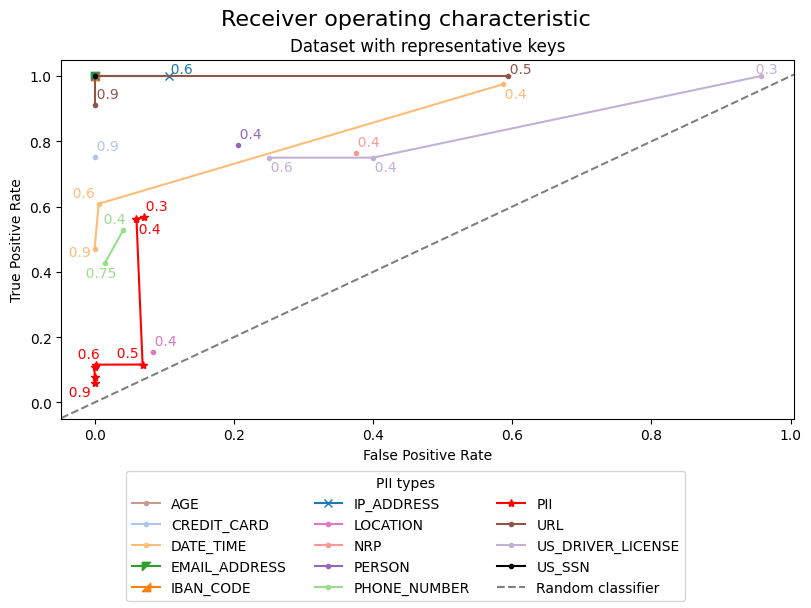

In [154]:
from typing import Tuple
# TODO: Plotter should take results_per_threshold and
#  plot an ROC curve using it.
#  Plotter internally forms the panda data frames. We can append an extra field to the EvaluationResult, that says something like confidence_threshold. Then append all results_per_threshold arrays and pass it to the plotter.
#  Plotter could plot the ROC using filters on the data frames e.g. filter out all dataframes with a given entity value (for all thresholds) and use it to create one lineplot, using the threshold value as the label of the lineplot.
#  Then create a second lineplot for a different entity value (e.g. LOCATION, IP_ADDRESS)
# Plot output
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

result_dicts = []
for threshold in results_per_threshold.keys():
    print(threshold)
    plotter = Plotter(results=results_per_threshold[threshold],
                      output_folder = "plots",
                      model_name = evaluator.model.name,
                      save_as="png",
                      beta = 2)
    scores = plotter.get_scores()
    scores["threshold"] = threshold
    df = pd.DataFrame(scores)
    result_dicts.append(df)

    # Entity | Precision | Recall |
    # Entity | Precision | Recall | Threshold

df = pd.concat(result_dicts)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    pass #print(df)

#  Going by the ROC definition, when the threshold increases, we expect lower TPR and lower FPR
#  We probs don't see a lower FPR. Why is that? e.g. is the FPR for the "PII" type the sum of the FPR for other types? Average
fig, ax = plt.subplots(figsize=(8,6), layout="constrained")
df = df[df["count"] != 0]         # TODO: what does count mean? num of annotations (ground truth) or predictions (observed occurrences)
#df = df[df["entity"] == "PII"]

masked_or_random = dataset_name.split(".")[0].split("_")[3]
def get_label_position(masked_or_random: str, pii_type:str, threshold:float) -> Tuple[int, int]:
    default_offsets = (-5, 5)
    labelxoffset, labelyoffset = default_offsets
    if masked_or_random == "random":
        return default_offsets
    if pii_type == "US_DRIVER_LICENSE":
        if threshold == 0.4 or threshold == 0.6:
            labelyoffset = -2 * labelyoffset
        if threshold == 0.3:
            labelxoffset = 2*labelxoffset # Shift it more to the left so it doesn't hit the x boundary
            labelyoffset = 0.5 * labelyoffset
    if pii_type == "URL":
        if threshold == 0.5:
            labelyoffset = 0.5 *labelyoffset
    if pii_type == "IP_ADDRESS":
        if threshold == 0.6:
            labelyoffset = 0.5 *labelyoffset
    if pii_type == "DATE_TIME":
        if threshold == 0.4:
            labelyoffset = -2 * labelyoffset
        if threshold == 0.6:
            labelxoffset = 5 *labelxoffset
        if threshold == 0.9:
            labelxoffset = 5 * labelxoffset
            labelyoffset = -1 * labelyoffset
    if pii_type == "PHONE_NUMBER":
        if threshold == 0.4:
            labelxoffset = 4 * labelxoffset
        if threshold == 0.75:
            labelyoffset = -2 * labelyoffset
            labelxoffset = 4 * labelxoffset
    if pii_type == "PII":
        if threshold == 0.4:
            labelyoffset = -2 * labelyoffset
        if threshold == 0.9:
            labelxoffset = 5 * labelxoffset
            labelyoffset = -2 * labelyoffset
        if threshold == 0.5:
            labelxoffset = 5 * labelxoffset
        if threshold == 0.6:
            labelxoffset = 4 * labelxoffset
    return labelxoffset, labelyoffset


#cmap = mpl.colormaps['tab20']
colors = plt.get_cmap('tab20').colors

# Maps each pii type to a color index in any paired color scheme with at least 20 colors
# The entity type "PII" should separately be set to black outside of this function
def map_pii_type_to_color_index(pii_type: str) -> int:
    mapping = {
        #First set light colors to all lines
        "URL": 10,
        "DATE_TIME": 3,
        "PHONE_NUMBER": 5,
        "US_DRIVER_LICENSE": 9,
        # Rest are the same
        "CREDIT_CARD": 1,
        "PERSON": 8,
        "NRP": 7,
        "LOCATION": 12,
        # Out of the rest, the next two show up as points on top of other lines
        "IP_ADDRESS":0,
        # These three don't show up at all
        "EMAIL_ADDRESS": 4,
        "IBAN_CODE": 2,
        "AGE": 11
    }
    return mapping[pii_type]

def should_annotate(pii_type: str, threshold: float) -> bool:
    if pii_type == "PII" and (threshold == 0.45 or threshold == 0.75 or threshold == 0.85):
        return False
    else:
        if pii_type == "EMAIL_ADDRESS" or pii_type == "IBAN_CODE" or pii_type == "US_SSN":
            return False
        if pii_type == "IP_ADDRESS" and threshold == 0.9:
            return False
        if pii_type == "URL" and threshold == 0.6:
            return False
        return True

colorcount=0
print(len(colors))
for pii_type, grp in df.groupby("entity"):
    grp = grp.drop_duplicates(subset=["precision","recall","fpr"], keep="last")
    print(pii_type)
    print(grp)
    if pii_type == "PII":
        marker = "*"
        color = "red"
    elif pii_type == "US_SSN":
        color = "black"
    else:
        color = colors[map_pii_type_to_color_index(pii_type)]
        if pii_type == "EMAIL_ADDRESS":
            marker = [[-1, -1], [-1, 1], [1, 1], [-1, -1]]
        elif pii_type == "IBAN_CODE":
            marker = [[-1, -1], [1, -1], [1, 1], [-1, -1]]
        elif pii_type == "IP_ADDRESS":
            marker = "x"
        else:
            marker = "."
    ax.plot(grp["fpr"],grp["recall"], data=grp, label=pii_type, marker=marker, color=color)
    for (fpr, recall, threshold) in zip(grp["fpr"], grp["recall"], grp["threshold"]):
        if should_annotate(pii_type, threshold):
            offset_for_this_point = get_label_position(masked_or_random, pii_type, threshold)
            ax.annotate("  %s" % threshold, xy=(fpr, recall), xytext=offset_for_this_point, textcoords="offset points", color=color)
    colorcount+=1

ax.axline((0, 0), slope=1, linestyle="--", label="Random classifier", color="gray")
ax.set_ylabel("True Positive Rate")
ax.set_xlabel("False Positive Rate")
masked_or_random = dataset_name.split(".")[0].split("_")[3]
title_keyword = "representative" if masked_or_random == "masked" else masked_or_random
plt.suptitle("Receiver operating characteristic", fontsize=16)
ax.set_title("Dataset with representative keys")
fig.legend(title="PII types", loc="outside lower center", ncols=3 )
#plt.show()
plt.savefig('plots/roc_' + masked_or_random + '.png')



# fig = px.scatter(data_frame=df, x="fpr", y="recall", title="ROC", color="entity", color_discrete_sequence=px.colors.qualitative.Light24)
# fig.update_layout(yaxis_title="True Positive Rate", xaxis_title="False Positive Rate",
#                       yaxis_range=[-0.05, 1.05], xaxis_range=[-0.05, 1.05]
#                       )


In [11]:
pprint({"PII F":results.pii_f, "PII recall": results.pii_recall, "PII precision": results.pii_precision})

{'PII F': 0.07459243309750846,
 'PII precision': 1.0,
 'PII recall': 0.060577673692427794}


## 8. Error analysis

Now let's look into results to understand what's behind the metrics we're getting.
Note that evaluation is never perfect. Some things to consider:
1. There's often a mismatch between the annotated span and the predicted span, which isn't necessarily a mistake. For example: `<Southern France>` compared with `Southern <France>`. In the second text, the word `Southern` was not annotated/predicted as part of the entity, but that's not necessarily an error.
2. Token based evaluation (which is used here) counts the number of true positive / false positive / false negative tokens. Some entities might be broken into more tokens than others. For example, the phone number `222-444-1234` could be broken into five different tokens, whereas `Krishna` would be broken into one token, resulting in phone numbers having more influence on metrics than names.
3. The synthetic dataset used here isn't representative of a real dataset. Consider using more realistic datasets for evaluation

In [12]:
plotter.plot_confusion_matrix(entities=entities, confmatrix=confmatrix)

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


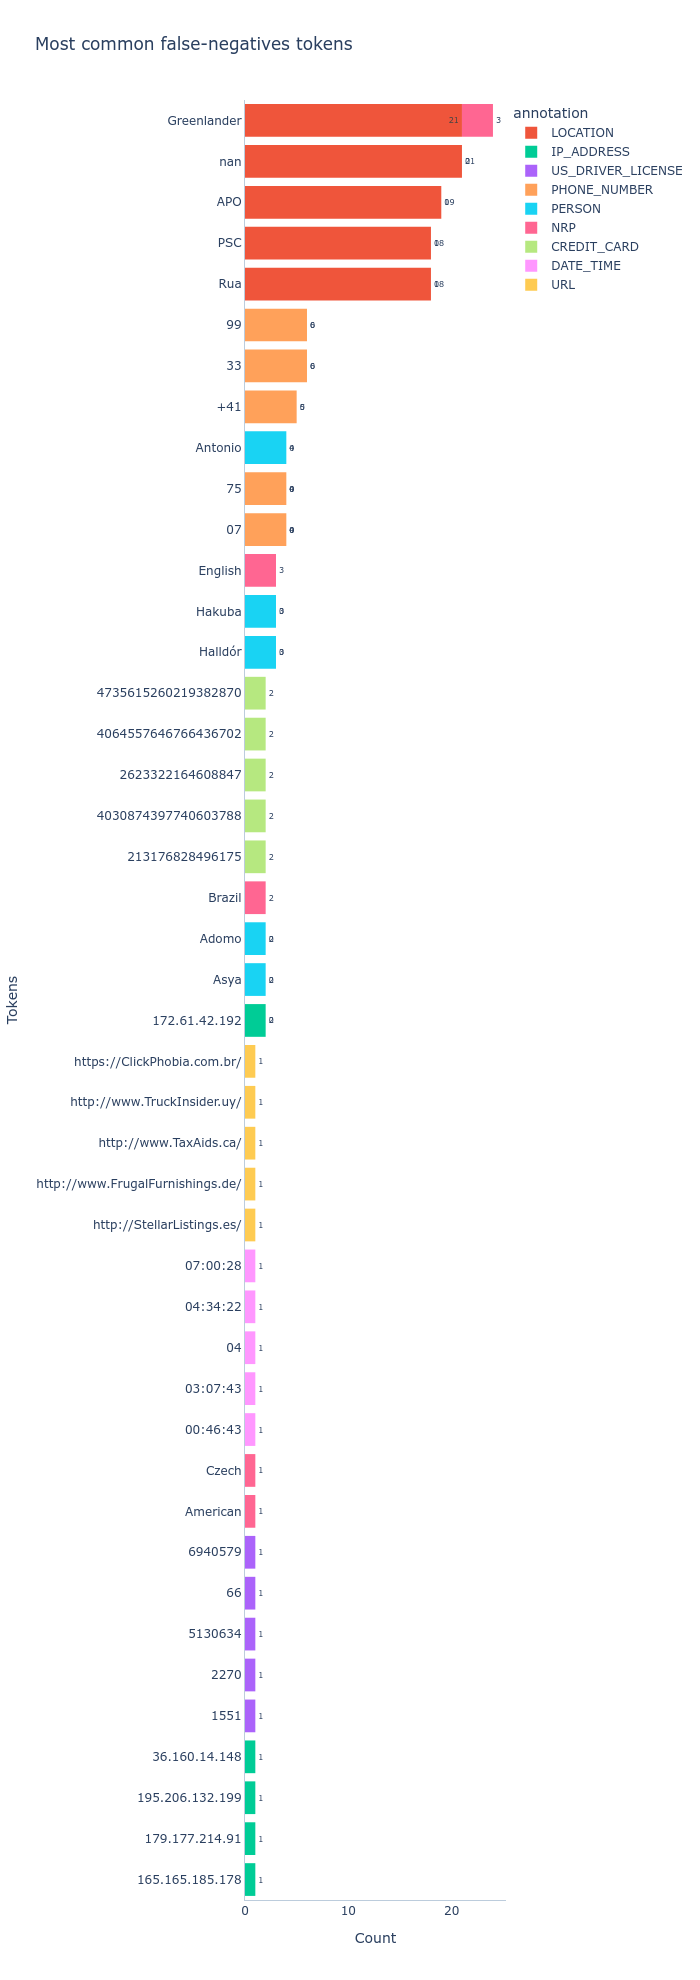

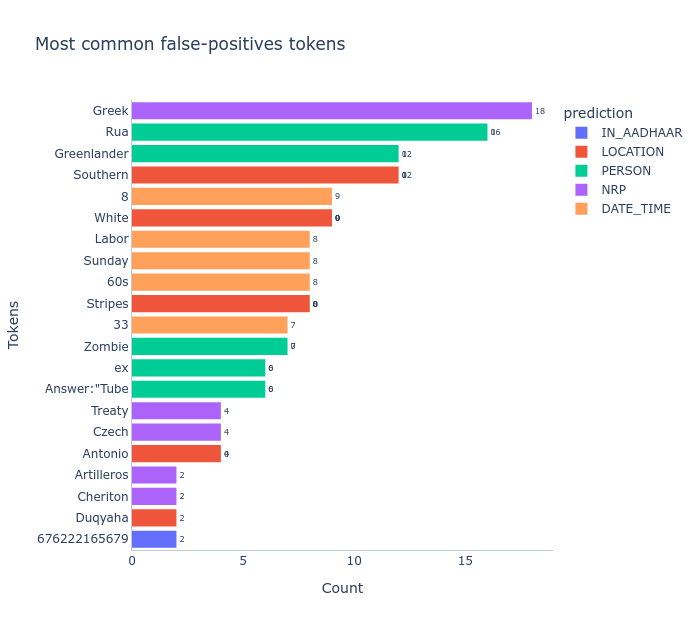

In [12]:
plotter.plot_most_common_tokens()

### 7a. False positives
#### Most common false positive tokens:

In [13]:
ModelError.most_common_fp_tokens(results.model_errors)

Most common false positive tokens:
[('Southern', 12),
 ('White', 9),
 ('8', 9),
 ('Greek', 9),
 ('Stripes', 8),
 ('60s', 8),
 ('Sunday', 8),
 ('Labor', 8),
 ('Rua', 8),
 ('couple', 7)]
---------------
Example sentence with each FP token:
	- The Exversion Orchestra was founded in 1977. Since then, it has grown from a volunteer community orchestra to a fully professional orchestra serving Southern Tunisia (`Southern` pred as LOCATION)
	- "The big three" of The Big Three Killed My Baby are the car manufacturers that dominate the economy of the White Stripes' home city Villafranca del Cid: White, Willis and Hoffman, Lucid and Loveland Technologies. "Don't feed me planned obsolescence," says Liisa Lepistö in an uncharacteristically political song, lamenting the demise of the unions in the 60s. (`White` pred as LOCATION)
	- Energetic and driven salesperson with 8+ years of professional experience in inbound and outbound sales. Awarded Salesperson of the Month three times. Helped increase inb

[('Southern', 12),
 ('White', 9),
 ('8', 9),
 ('Greek', 9),
 ('Stripes', 8),
 ('60s', 8),
 ('Sunday', 8),
 ('Labor', 8),
 ('Rua', 8),
 ('couple', 7)]

#### More FP analysis

In [14]:
fps_df = ModelError.get_fps_dataframe(results.model_errors, entity=["PERSON"])
fps_df[["full_text", "token", "annotation", "prediction"]].head(20)

,full_text,token,annotation,prediction
0,"Krisztián Szöllösy listed his top 20 songs for Entertainment Weekly and had the balls to list this song at #15. (What did he put at #1 you ask? Answer:""Tube Snake Boogie"" by Szabina J Gelencsér ג€“ go figure)","Answer:""Tube",O,PERSON
1,"Krisztián Szöllösy listed his top 20 songs for Entertainment Weekly and had the balls to list this song at #15. (What did he put at #1 you ask? Answer:""Tube Snake Boogie"" by Szabina J Gelencsér ג€“ go figure)",Snake,O,PERSON
2,"Krisztián Szöllösy listed his top 20 songs for Entertainment Weekly and had the balls to list this song at #15. (What did he put at #1 you ask? Answer:""Tube Snake Boogie"" by Szabina J Gelencsér ג€“ go figure)",Boogie,O,PERSON
3,"Krisztián Szöllösy listed his top 20 songs for Entertainment Weekly and had the balls to list this song at #15. (What did he put at #1 you ask? Answer:""Tube Snake Boogie"" by Szabina J Gelencsér ג€“ go figure)",ג€,O,PERSON
4,"Verdafero is the brainchild of our 3 founders: Eklund, Michael and Hodge. The idea was born (on the beach) while they were constructing a website to be the basis of another start-up idea.",Verdafero,O,PERSON
5,"The title refers to 1668 Glyn St street in Highveld. It was on this street that many of the clubs where Metallica first played were situated. ""Battery is found in me"" shows that these early shows on Marina Fort Street were important to them. Battery is where ""lunacy finds you"" and you ""smash through the boundaries.""",Metallica,O,PERSON
6,"James Talbot listed his top 20 songs for Entertainment Weekly and had the balls to list this song at #15. (What did he put at #1 you ask? Answer:""Tube Snake Boogie"" by Natalie Åberg ג€“ go figure)","Answer:""Tube",O,PERSON
7,"James Talbot listed his top 20 songs for Entertainment Weekly and had the balls to list this song at #15. (What did he put at #1 you ask? Answer:""Tube Snake Boogie"" by Natalie Åberg ג€“ go figure)",Snake,O,PERSON
8,"James Talbot listed his top 20 songs for Entertainment Weekly and had the balls to list this song at #15. (What did he put at #1 you ask? Answer:""Tube Snake Boogie"" by Natalie Åberg ג€“ go figure)",Boogie,O,PERSON
9,"The Davis, Reynolds and Williamson Orchestra was founded in 1977. Since then, it has grown from a volunteer community orchestra to a fully professional orchestra serving Southern Italy",Davis,O,PERSON


### 7b. False negatives (FN)

#### Most common false negative examples + a few samples with FN

In [15]:
ModelError.most_common_fn_tokens(results.model_errors, n=15)

Most common false negative tokens:
[('nan', 20),
 ('APO', 19),
 ('PSC', 18),
 ('Greenlander', 18),
 ('AA', 16),
 ('ul', 14),
 ('AP', 11),
 ('AE', 11),
 ('DPO', 10),
 ('Rua', 10),
 ('FPO', 9),
 ('33', 9),
 ('Greek', 9),
 ('Cite', 8),
 ('Cyprus', 7)]
---------------
Example sentence with each FN token:
	- Billing address: Sophie Lang
    3482 Via Franscini 71 Suite 838
   Tujetsch
    nan
    7188 (`nan` annotated as LOCATION)
	- The Avalara office is at PSC 0413, Box 8144
APO AA 42323 (`APO` annotated as LOCATION)
	- The Avalara office is at PSC 0413, Box 8144
APO AA 42323 (`PSC` annotated as LOCATION)
	- Marisa Bisliev

583 Magrethevej 298
 Apt. 123
 Qasigiannguit
 Greenlander 07609 (`Greenlander` annotated as LOCATION)
	- The Avalara office is at PSC 0413, Box 8144
APO AA 42323 (`AA` annotated as LOCATION)
	- Bot: Where would you like this to be sent to? User: Hanne and ul. Więckowskiego Stefana 28 (`ul` annotated as LOCATION)
	- Hello I moved, please update my new address is PSC 6293

[('nan', 20),
 ('APO', 19),
 ('PSC', 18),
 ('Greenlander', 18),
 ('AA', 16),
 ('ul', 14),
 ('AP', 11),
 ('AE', 11),
 ('DPO', 10),
 ('Rua', 10),
 ('FPO', 9),
 ('33', 9),
 ('Greek', 9),
 ('Cite', 8),
 ('Cyprus', 7)]

#### More FN analysis

In [16]:
fns_df = ModelError.get_fns_dataframe(results.model_errors, entity=["PHONE_NUMBER"])

In [17]:
fns_df[["full_text", "token", "annotation", "prediction"]].head(20)

,full_text,token,annotation,prediction
0,I have done an online order but didn't get any message on my registered 905-674-3793. Could you please look into it ?,905,PHONE_NUMBER,O
1,I have done an online order but didn't get any message on my registered 905-674-3793. Could you please look into it ?,674,PHONE_NUMBER,O
2,I have done an online order but didn't get any message on my registered 905-674-3793. Could you please look into it ?,3793,PHONE_NUMBER,O
3,Janka M. Szász\n\nNetwork and computer systems administrator\n\nPersonal Info:\nPhone:\n60-56-85-91\n\nE-mail:\nSzaszJanka@cuvox.de\n\nWebsite:\nhttps://www.UEarly.se/\n\nAddress:\nBrucker Bundesstrasse 31 Zezig Streets\n Suite 245\n FÜRLING\n Austria 25173.,60,PHONE_NUMBER,O
4,Janka M. Szász\n\nNetwork and computer systems administrator\n\nPersonal Info:\nPhone:\n60-56-85-91\n\nE-mail:\nSzaszJanka@cuvox.de\n\nWebsite:\nhttps://www.UEarly.se/\n\nAddress:\nBrucker Bundesstrasse 31 Zezig Streets\n Suite 245\n FÜRLING\n Austria 25173.,56,PHONE_NUMBER,O
5,Janka M. Szász\n\nNetwork and computer systems administrator\n\nPersonal Info:\nPhone:\n60-56-85-91\n\nE-mail:\nSzaszJanka@cuvox.de\n\nWebsite:\nhttps://www.UEarly.se/\n\nAddress:\nBrucker Bundesstrasse 31 Zezig Streets\n Suite 245\n FÜRLING\n Austria 25173.,85,PHONE_NUMBER,O
6,Janka M. Szász\n\nNetwork and computer systems administrator\n\nPersonal Info:\nPhone:\n60-56-85-91\n\nE-mail:\nSzaszJanka@cuvox.de\n\nWebsite:\nhttps://www.UEarly.se/\n\nAddress:\nBrucker Bundesstrasse 31 Zezig Streets\n Suite 245\n FÜRLING\n Austria 25173.,91,PHONE_NUMBER,O
7,"Gregory Kudryashov\n\n233 Erzsébet tér 19.\n Suite 282\n Domoszló\n Hungary 34796\n(37) 788-063-Office\,07700 063 966-Fax",37,PHONE_NUMBER,O
8,"Gregory Kudryashov\n\n233 Erzsébet tér 19.\n Suite 282\n Domoszló\n Hungary 34796\n(37) 788-063-Office\,07700 063 966-Fax",788,PHONE_NUMBER,O
9,"Gregory Kudryashov\n\n233 Erzsébet tér 19.\n Suite 282\n Domoszló\n Hungary 34796\n(37) 788-063-Office\,07700 063 966-Fax",063,PHONE_NUMBER,O
